# Outflow forecasting with LSTM with Constraint Validation for sustainable HFPVHP Project Overview

This notebook demonstrates a complete workflow for predicting water releases (outflow) from a reservoir, using a machine learning model (LSTM) and validating the predictions with a mathematical constraint solver (RealPaver).

The project combines historical reservoir data, a neural network model to predict short-term behavior, and a formal validation step to ensure the predictions are physically feasible.


## Step 1: Load and Explore Historical Reservoir Data

We begin by loading a CSV file that contains daily measurements from a water reservoir. These measurements include:

- **Storage**: how much water is in the reservoir at the start of the day (in acre-feet).
- **Inflow**: how much water flowed into the reservoir that day.
- **Outflow**: how much water was intentionally released.
- **Unaccounted**: small changes in storage that don't match inflow and outflow exactly (e.g., evaporation, leaks).

This data will serve as both input and training material for our prediction model.


## Step 2: Prepare the Data for the Neural Network

The model needs consistent numeric data. We select the past 30 days of storage, inflow, outflow, and unaccounted values to predict the next 10 days of outflow.

This means that for every example in training:
- The input is 30 days of previous data.
- The output (what we're training the model to predict) is 10 future outflow values.


## Step 3: Train the LSTM Neural Network

We use a type of recurrent neural network called an **LSTM (Long Short-Term Memory)**. It's designed to recognize patterns over time and is especially good with sequences like weather or water data.

We train the model over several rounds (called epochs), where it learns to reduce its prediction error. Once trained, it can forecast the future outflow from the reservoir based on recent trends.


epoch 1/5 - loss 0.001300
epoch 2/5 - loss 0.000876
epoch 3/5 - loss 0.001244
epoch 4/5 - loss 0.000937
epoch 5/5 - loss 0.000838
MSE: 15682082059.620129
MAE: 96215.67712682887


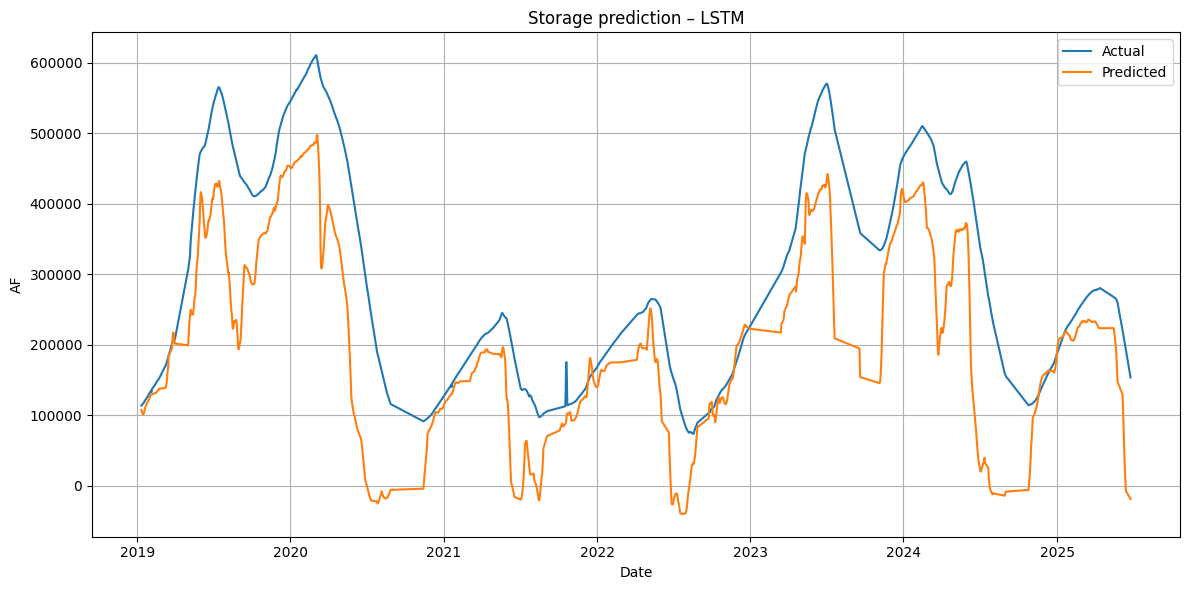

In [ ]:
# Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(40)

# Load & preprocess
df = (
    pd.read_csv("Elephant_Butte.csv", parse_dates=["date"])
      .loc[:, ["date", "storage", "inflow_af", "outflow_af"]]
      .dropna()
      .set_index("date")
      .astype(float)
)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)          # storage is column 0

SEQ = 10                                    # look-back length


def make_windows(arr, seq):
    X, y = [], []
    for i in range(seq, len(arr)):
        X.append(arr[i - seq:i])
        y.append(arr[i, 0])                 # predict storage only
    return np.array(X), np.array(y).reshape(-1, 1)


X, y = make_windows(scaled, SEQ)
split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]

# Minimal NumPy LSTM
class Adam:
    def __init__(self, lr=1e-3, b1=0.9, b2=0.999, eps=1e-8):
        self.lr, self.b1, self.b2, self.eps = lr, b1, b2, eps
        self.m, self.v, self.t = {}, {}, 0

    def step(self, p, g, k):
        self.t += 1
        self.m[k] = self.b1 * self.m.get(k, 0) + (1 - self.b1) * g
        self.v[k] = self.b2 * self.v.get(k, 0) + (1 - self.b2) * (g * g)
        m_hat = self.m[k] / (1 - self.b1 ** self.t)
        v_hat = self.v[k] / (1 - self.b2 ** self.t)
        return p - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)


class LSTM:
    def __init__(self, input_dim, hidden_dim=64, lr=1e-3):
        self.h, self.d, self.opt = hidden_dim, input_dim, Adam(lr)

        def xavier(a, b): return np.random.randn(a, b) * np.sqrt(1 / b)

        self.W = {g: xavier(hidden_dim, hidden_dim + input_dim + 1) for g in "fico"}
        self.b = {g: np.zeros((hidden_dim, 1)) for g in "fico"}
        self.Wy = xavier(1, hidden_dim)
        self.by = np.zeros((1, 1))

    @staticmethod
    def σ(x): return 1 / (1 + np.exp(-x))
    @staticmethod
    def τ(x): return np.tanh(x)

    def forward(self, seq, need_cache=False):
        h = np.zeros((self.h, 1))
        c = np.zeros_like(h)
        cache = []
        for x in seq:
            x = x.reshape(-1, 1)
            z = np.vstack([h, [[1.0]], x])
            f, i, o = (self.σ(self.W[g] @ z + self.b[g]) for g in "fio")
            g = self.τ(self.W["c"] @ z + self.b["c"])
            c_prev = c
            c = f * c + i * g
            h = o * self.τ(c)
            if need_cache:
                cache.append((z, f, i, o, g, c_prev, c, h))
        y = self.Wy @ h + self.by
        return (y, cache) if need_cache else y

    # Mean-squared error
    @staticmethod
    def mse(p, t): return np.mean((p - t) ** 2)

    def _bptt(self, cache, target, pred):
        dy = 2 * (pred - target)
        dWy, dby = dy @ cache[-1][-1].T, dy.copy()
        dh = self.Wy.T @ dy
        dc = np.zeros((self.h, 1))
        dW = {g: np.zeros_like(self.W[g]) for g in "fico"}
        db = {g: np.zeros_like(self.b[g]) for g in "fico"}

        for z, f, i, o, g, c_prev, c, h in reversed(cache):
            do = dh * self.τ(c) * o * (1 - o)
            dtanh = dh * o * (1 - self.τ(c) ** 2)
            dc += dtanh
            df = dc * c_prev * f * (1 - f)
            di = dc * g * i * (1 - i)
            dg = dc * i * (1 - g ** 2)
            for gate, din in zip("fio", (df, di, do)):
                dW[gate] += din @ z.T
                db[gate] += din
            dW["c"] += dg @ z.T
            db["c"] += dg
            dz = (self.W["f"].T @ df + self.W["i"].T @ di +
                  self.W["o"].T @ do + self.W["c"].T @ dg)
            dh, dc = dz[:self.h], dc * f
        return dW, db, dWy, dby

    def _apply_grads(self, grads):
        dW, db, dWy, dby = grads
        for g in "fico":
            self.W[g] = self.opt.step(self.W[g], dW[g], f"W{g}")
            self.b[g] = self.opt.step(self.b[g], db[g], f"b{g}")
        self.Wy = self.opt.step(self.Wy, dWy, "Wy")
        self.by = self.opt.step(self.by, dby, "by")

    def fit(self, X, y, epochs=5):
        for e in range(1, epochs + 1):
            losses = []
            for seq, tgt in zip(X, y):
                pred, cache = self.forward(seq, need_cache=True)
                losses.append(self.mse(pred, tgt))
                self._apply_grads(self._bptt(cache, tgt, pred))
            print(f"epoch {e}/{epochs} - loss {np.mean(losses):.6f}")


# Train
model = LSTM(input_dim=X.shape[2], hidden_dim=64, lr=1e-3)
model.fit(X_train, y_train, epochs=5)

# Predict & invert scale
pred = np.array([model.forward(seq) for seq in X_test]).reshape(-1, 1)

pad = np.zeros((len(pred), 2))              # two dummy cols to match scaler
pred_inv = scaler.inverse_transform(np.hstack([pred, pad]))[:, 0:1]
true_inv = scaler.inverse_transform(np.hstack([y_test, pad]))[:, 0:1]

print("MSE:", mean_squared_error(true_inv, pred_inv))
print("MAE:", mean_absolute_error(true_inv, pred_inv))

#Plot
plt.figure(figsize=(12, 6))
t_idx = df.index[-len(pred_inv):]           # align with test segment
plt.plot(t_idx, true_inv, label="Actual")
plt.plot(t_idx, pred_inv, label="Predicted")
plt.title("Storage prediction – LSTM")
plt.xlabel("Date"); plt.ylabel("AF")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## Step 4: Generate a Forecast for Future Outflow

Now that our model is trained, we use it to forecast 10 days of future water releases (from June 3 to June 12, 2025).

This simulates what we might do in a real operations setting: use data up to June 1 to generate a 10-day forecast.


train shapes: (9242, 30, 1) (9242, 10)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,546 (68.54 KB)

 Trainable params: 17,546 (68.54 KB)

 Non-trainable params: 0 (0.00 B)

final train loss: 0.007896652445197105
MSE: 21317.543528622387
MAE: 133.4562255859375


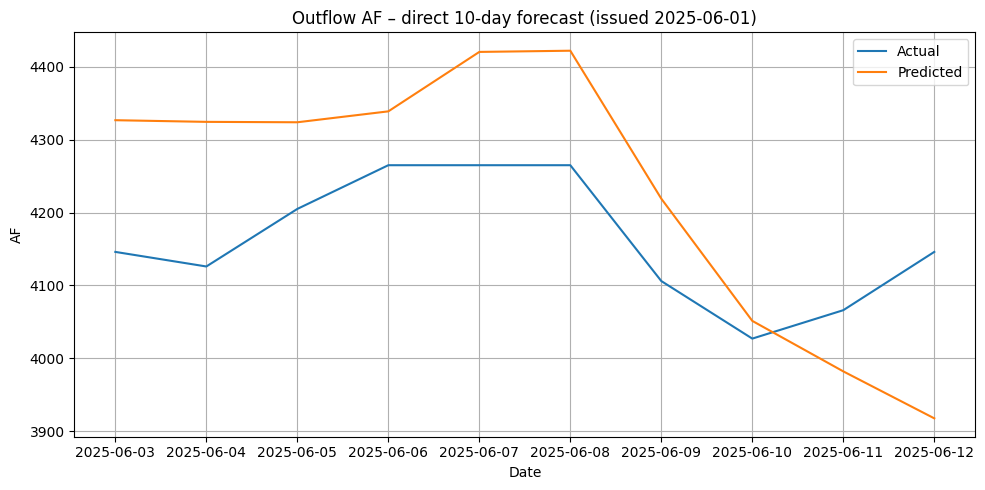

In [ ]:
# Imports

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
tf.random.set_seed(40)
np.random.seed(40)

# Load CSV, keep outflow only

df = pd.read_csv("Elephant_Butte.csv", parse_dates=["date"]).set_index("date")
df["outflow_af"] = pd.to_numeric(df["outflow_af"], errors="coerce").ffill()

# train up to (and including) 2025-06-01
cutoff = pd.Timestamp("2025-06-02")
train_series = df.loc[:cutoff - pd.Timedelta(days=1), "outflow_af"].values.reshape(-1,1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(train_series)             # 0-1 range

SEQ   = 30    # look-back window
HORIZ = 10    # forecast length (06-03 .. 06-12)

def make_supervised(arr, seq, horiz):
    X, y = [], []
    for i in range(seq, len(arr) - horiz + 1):
        X.append(arr[i-seq:i])
        y.append(arr[i:i+horiz, 0])                     # 1-D target
    return np.array(X), np.array(y)

X_train, y_train = make_supervised(scaled, SEQ, HORIZ)
print("train shapes:", X_train.shape, y_train.shape)    # (samples, 30, 1) & (samples, 10)

# Build & train Keras LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ,1)),
    tf.keras.layers.LSTM(64, activation="tanh"),
    tf.keras.layers.Dense(HORIZ)                        # 10 outputs, one per day
])
model.compile(optimizer="adam", loss="mse")
model.summary()

history = model.fit(X_train, y_train,
                    epochs=50, batch_size=32, verbose=0) # silent; tweak epochs as you like
print("final train loss:", history.history["loss"][-1])

# Issue forecast for 2025-06-03 .. 06-12

last_window = scaled[-SEQ:].reshape(1, SEQ, 1)          # window ending 2025-06-01
pred_scaled = model.predict(last_window, verbose=0).reshape(-1,1)
pred = scaler.inverse_transform(pred_scaled).flatten()

forecast_idx = pd.date_range("2025-06-03", periods=HORIZ, freq="D")
actual = df.loc[forecast_idx, "outflow_af"].values

# Metrics & plot
print("MSE:", mean_squared_error(actual, pred))
print("MAE:", mean_absolute_error(actual, pred))

plt.figure(figsize=(10,5))
plt.plot(forecast_idx, actual, label="Actual")
plt.plot(forecast_idx, pred,   label="Predicted")
plt.title("Outflow AF – direct 10-day forecast (issued 2025-06-01)")
plt.xlabel("Date"); plt.ylabel("AF"); plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


## Step 5: Create a RealPaver Constraint File

To check if our forecast is physically realistic, we generate a `.rp` file for RealPaver. This file includes:

- Initial storage level
- Predicted outflow values
- Storage limits
- Change factors from unaccounted losses or gains
- A total release range (e.g., due ± delta)

This is a formal representation of the problem we want to validate.


In [ ]:
import pandas as pd
from typing import List, Optional

# Helper class with forecast-aware RealPaver writer
class WaterConstraints:
    def __init__(self, time_stamps, reservoir_min, reservoir_max,
                 due, delta):
        self.time_stamps   = time_stamps
        self.vars          = [f"R{i+1}" for i in range(time_stamps)]
        self.differentials = [0.0] * time_stamps
        self.water_level0  = 0
        self.max_release   = 2_000_000            # fixed upper bound
        self.reservoir_min = reservoir_min
        self.reservoir_max = reservoir_max
        self.due           = due
        self.delta         = delta

    def get_data_from_file(self, filename, delay):
        df = pd.read_csv(filename)
        self.water_level0  = int(df.iloc[0, 1])                       # storage
        delayed_df         = df.iloc[delay : delay + self.time_stamps]
        self.differentials = delayed_df.iloc[:, 4].astype(float).tolist()


    # RealPaver writer  (supports fixed or interval forecasts)
    def write_rp_constraint_file(self, filename,
                                 forecast: Optional[List[float]] = None,
                                 tol: float = 0.0):
        with open(filename, "w") as w:
            w.write("/* Water Project\n")
            w.write(" * Experiment with RealPaver\n")
            w.write("*/\n\n")

            # constants
            w.write("Constants\n")
            w.write(f"     w0 = {self.water_level0},\n")
            for i, d in enumerate(self.differentials):
                w.write(f"     c{i+1} = {d},\n")
            w.write(f"     reservoirMin = {self.reservoir_min},\n")
            w.write(f"     reservoirMax = {self.reservoir_max},\n")
            w.write(f"     due = {self.due},\n")
            w.write(f"     delta = {self.delta};\n\n")

            # variables
            w.write("Variables\n")
            for i, var in enumerate(self.vars):
                end = "," if i < self.time_stamps - 1 else ";"
                w.write(f"     {var} in [0, {self.max_release}]{end}\n")
            w.write("\n")

            # solving mode
            w.write("Branch precision = 0.01,\n")
            w.write("mode = paving,\n")
            w.write("parts = 4;\n\n")

            # constraints
            w.write("Constraints\n")

            # fixed values or small intervals around each forecast
            if forecast is not None:
                for i, p in enumerate(forecast):
                    if tol == 0:
                        w.write(f"     R{i+1} = {p:.2f},\n")
                    else:
                        w.write(f"     R{i+1} in [{p-tol:.2f}, {p+tol:.2f}],\n")

            # daily storage bounds
            for i in range(self.time_stamps):
                expr = "     w0" + "".join(
                    [f" + c{j+1} - R{j+1}" for j in range(i + 1)]
                )
                w.write(f"{expr} >= reservoirMin,\n")
                w.write(f"{expr} <= reservoirMax,\n")

            # total-release band (final line ends with ';')
            sum_expr = " + ".join(self.vars)
            w.write(f"     {sum_expr} >= due,\n")
            w.write(f"     {sum_expr} <= due + delta;\n")

        print(f"Constraint file written to {filename}")

# Build constraint file from the LSTM forecast
assert "pred" in globals(), "Run the forecasting cell first"

HORIZ          = len(pred)                      # 10-day horizon
forecast_list  = pred.tolist()

# make total-release bounds consistent with the forecast
due_val   = int(sum(forecast_list))             # centre of the band
delta_val = int(0.10 * due_val)                 # ±10 % tolerance

water = WaterConstraints(time_stamps   = HORIZ,
                         reservoir_min = 100_000,
                         reservoir_max = 1_700_000,
                         due           = due_val,
                         delta         = delta_val)

water.get_data_from_file("Elephant_Butte.csv", delay=5)

# tol = 0  → fixed releases; increase for small intervals
water.write_rp_constraint_file("forecast_2025_06_01.rp",
                               forecast = forecast_list,
                               tol      = 0.0)


Constraint file written to forecast_2025_06_01.rp


## Step 6: Validate the Forecast with RealPaver

We run RealPaver on the `.rp` file. It verifies whether there is a mathematically valid way to schedule the predicted releases without violating the reservoir constraints.

If the solution box exists and is narrow, the prediction is validated as physically feasible.
